### This notebook is an extension of 08.Federated_Learning_with_Testing_and_model_saving and shows how to use a saved model to perform prediction on a test set

In [35]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [36]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch

import h5py

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from argparse import Namespace
import pandas as pd

In [37]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [38]:
from ml.utils.train_utils import train, test

In [39]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [40]:
from ml.utils.helpers import accumulate_metric

In [41]:

args = Namespace(
    data_path='../dataset/cluster_split/cluster_2.csv', # dataset
    data_path_test=None , # test dataset
    test_size=0.2, # validation size
    targets=['power_output'], # the target columns
    num_lags= 24, # the number of past observations to feed as input

    identifier='GSRN', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=None, # whether to perform flooring and capping

    
    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=10, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fedavg", # federated aggregation algorithm
    epochs=3, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False, # whether to use datetime features
    
    forecast_horizon = 3 # forecast horizon
)

In [42]:
STATIC_FEATURE_COLUMNS = ["age", "Capacity_kw"]

def compute_static_feature_stats(data_path, static_cols):
    df = read_data(data_path)
    stats = {}
    for col in static_cols:
        if col not in df.columns:
            continue
        series = df[col].dropna()
        if series.empty:
            continue
        stats[col] = {"min": float(series.min()), "max": float(series.max())}
    return stats

def minmax_scale_static_lags(df, stats):
    if not stats:
        return df
    df = df.copy()
    static_cols = [col for col in df.columns if any(base in col for base in STATIC_FEATURE_COLUMNS)]
    for col in static_cols:
        base = next((base for base in STATIC_FEATURE_COLUMNS if base in col), None)
        if base is None or base not in stats:
            continue
        col_min = stats[base]["min"]
        col_max = stats[base]["max"]
        denom = col_max - col_min if col_max != col_min else 1.0
        df[col] = (df[col] - col_min) / denom
    return df

static_feature_stats = compute_static_feature_stats(args.data_path, STATIC_FEATURE_COLUMNS)

PLOT_WINDOW_SIZE = 24


In [43]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("current used device:", device)

current used device: mps


In [44]:
class ModelLoader:
    def __init__(self, model_path: str, to_torch: bool = True):
        self.model_path = model_path
        self.to_torch = to_torch

    def load(self):
        state_dict = OrderedDict()
        x_scaler, y_scaler = OrderedDict(), OrderedDict()

        with h5py.File(self.model_path, "r") as f:
            keys = list(f.keys())
            assert "model_weights" in keys
            assert "x_scaler" in keys
            assert "y_scaler" in keys

            # 1. 模型权重
            model_weights = f["model_weights"]
            for k in model_weights:
                state_dict[k] = model_weights[k][()]

            # 2. x_scaler：每个 client 有多个 scaler 属性
            for client_id in f["x_scaler"]:
                scaler_attrs = {}
                for attr in f["x_scaler"][client_id]:
                    scaler_attrs[attr] = f["x_scaler"][client_id][attr][()]
                x_scaler[client_id] = scaler_attrs

            # 3. y_scaler
            for client_id in f["y_scaler"]:
                scaler_attrs = {}
                for attr in f["y_scaler"][client_id]:
                    scaler_attrs[attr] = f["y_scaler"][client_id][attr][()]
                y_scaler[client_id] = scaler_attrs

        if self.to_torch:
            state_dict = self.state_to_torch(state_dict)

        return state_dict, x_scaler, y_scaler

    @staticmethod
    def state_to_torch(model_state):
        assert isinstance(model_state, (dict, OrderedDict))
        k = next(iter(model_state))
        assert isinstance(model_state[k], (np.ndarray, torch.Tensor))
        if isinstance(model_state[k], torch.Tensor):
            return model_state
        return OrderedDict({k: torch.tensor(v).float() for k, v in model_state.items()})

In [45]:
def set_minmax_attrs(scaler_attrs):
    scaler = MinMaxScaler()
    scaler.min_ = scaler_attrs["min_"]
    scaler.scale_ = scaler_attrs["scale_"]
    scaler.data_min_ = scaler_attrs["data_min_"]
    scaler.data_max_ = scaler_attrs["data_max_"]
    scaler.data_range_ = scaler_attrs["data_range_"]
    scaler.n_features_in_ = int(scaler_attrs["n_features_in_"][0])
    scaler.n_samples_seen_ = int(scaler_attrs["n_samples_seen_"][0])

    if "feature_names_in_" in scaler_attrs and scaler_attrs["feature_names_in_"] is not None:
        # 解码字节串为字符串
        scaler.feature_names_in_ = np.array([s.decode("utf-8") for s in scaler_attrs["feature_names_in_"]])
    
    return scaler

In [46]:
import h5py

with h5py.File("model_checkpoint/scalers_cluster2.h5", "r") as f:
    print("Keys in HDF5 file:", list(f.keys()))

Keys in HDF5 file: ['x_scaler', 'y_scaler']


In [47]:
model_loader = ModelLoader("model_checkpoint/full_model_cluster2.h5")
state_dict, x_scaler, y_scaler = model_loader.load()

In [48]:
# load raw dicts
state_dict, x_scaler_raw, y_scaler_raw = model_loader.load()

# restore sklearn scalers
x_scaler = {cid: set_minmax_attrs(attrs) for cid, attrs in x_scaler_raw.items()}
y_scaler = {cid: set_minmax_attrs(attrs) for cid, attrs in y_scaler_raw.items()}

In [49]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [50]:
def get_input_dims(X_test, exogenous_data_test):
    if args.model_name == "mlp":
        input_dim = X_test.shape[1] * X_test.shape[2]
    else:
        input_dim = X_test.shape[2]
    
    if exogenous_data_test is not None:
        if len(exogenous_data_test) == 1:
            cid = next(iter(exogenous_data_test.keys()))
            exogenous_dim = exogenous_data_test[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_test["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [51]:
def transform_preds_test(y_pred_test):
    if not isinstance(y_pred_test, np.ndarray):
        y_pred_test = y_pred_test.cpu().numpy()
    return y_pred_test

def inverse_minmax_multi(values, scaler):
    values = np.asarray(values)
    if values.ndim == 1:
        values = values.reshape(-1, 1)
    cols = []
    for idx in range(values.shape[1]):
        cols.append(scaler.inverse_transform(values[:, [idx]]))
    return np.hstack(cols)

def inverse_transform_test(
    y_test, y_pred_test,
    y_scaler=None, 
    round_preds=False,
    dims=None):
    
    y_pred_test = transform_preds_test(y_pred_test)

    if y_scaler is not None:
        y_test = inverse_minmax_multi(y_test, y_scaler)
        y_pred_test = inverse_minmax_multi(y_pred_test, y_scaler)

    y_pred_test[y_pred_test < 0.] = 0.
    return y_test, y_pred_test


In [52]:
def predict(
    model,
    cid,
    X_test,
    y_test,
    exogenous_data_test,
    plot,
    idxs=None,
    apply_round=False,
    round_dimensions=[],
    y_scaler=None,
    timestamps=None,
    plot_window_size=PLOT_WINDOW_SIZE
):
    if "test" in cid:
        tmp_cid = cid.split("_")
        for s_t in tmp_cid:
            if s_t != "test":
                cid = s_t
                break

    num_features = len(X_test[0][0])

    test_loader = to_torch_dataset(
        X_test, y_test,
        num_lags=args.num_lags,
        num_features=num_features,
        exogenous_data=exogenous_data_test,
        indices=idxs,
        batch_size=1,
        shuffle=False
    )

    (
        test_mse_raw,
        test_rmse_raw,
        test_mae_raw,
        test_r2_raw,
        test_nrmse_raw,
        y_pred_test
    ) = test(model, test_loader, None, device=device)

    y_test, y_pred_test = inverse_transform_test(
        y_test, y_pred_test,
        y_scaler=y_scaler,
        round_preds=apply_round,
        dims=round_dimensions
    )

    (
        test_mse,
        test_rmse,
        test_mae,
        test_r2,
        test_nrmse,
        test_res_per_dim,
        sse_test,
        sst_test
    ) = accumulate_metric(
        y_test, y_pred_test, log_per_output=True, return_all=True, return_sse_sst=True
    )

    print(f"📈 Final Prediction in {cid}")
    print(f"[Test]: mse: {test_mse:.4f}, rmse: {test_rmse:.4f}, mae: {test_mae:.4f}, "          f"r2: {test_r2:.4f}, nrmse: {test_nrmse:.4f}, sse: {sse_test:.4f}, sst: {sst_test:.4f}\n")

    if plot:
        make_plot(
            y_true=y_test,
            y_pred=y_pred_test,
            timestamps=timestamps,
            title="Test",
            client=cid,
            window_size=plot_window_size
        )


In [53]:
def make_plot(y_true, y_pred, timestamps, title="Forecast Next 3 Hours", client=None, window_size=24):
    """
    将 t+1, t+2, t+3 的预测分别绘制成三条线，对应实际值和预测值（共6条线）。
    去掉了对“第一个非全0”的过滤逻辑，直接从头开始绘制。
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    assert y_true.shape == y_pred.shape
    assert len(y_true.shape) == 2
    assert len(timestamps) >= 1

    forecast_horizon = y_true.shape[1]

    # 不再过滤，只截取前 window_size 个 sample
    end_idx = min(window_size, len(y_true))
    y_true_window = y_true[:end_idx]
    y_pred_window = y_pred[:end_idx]
    ts_window = timestamps[:end_idx]

    base_times = pd.to_datetime(ts_window)

    plt.figure(figsize=(14, 6))
    for h in range(forecast_horizon):
        true_series = y_true_window[:, h]
        pred_series = y_pred_window[:, h]
        horizon_label = f"t+{h+1}"

        plt.plot(base_times, true_series, '--', label=f"Actual {horizon_label}")
        plt.plot(base_times, pred_series, '-', label=f"Predicted {horizon_label}")

    plt.xticks(rotation=45)
    plt.xlabel("Time")
    plt.ylabel("Power Output (kW)")

    title_str = f"[{client}] {title}" if client else title
    plt.title(title_str)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [54]:
from sklearn.preprocessing import StandardScaler

def model_test(
    model,
    data_paths,                     # list of CSV file paths
    x_scaler_dict,                  # dict[str, StandardScaler]
    y_scaler_dict,                  # dict[str, StandardScaler]
    plot=True,
    idxs=None,
    round_predictions=False,
    round_dimensions=None,
):
    if round_dimensions is None:
        round_dimensions = []

    for path in data_paths:
        cid = os.path.splitext(os.path.basename(path))[0]
        print(f"📦 Processing {cid}")

        df = read_data(path)
        if args.identifier not in df.columns:
            df[args.identifier] = cid

        if args.identifier not in df.columns:
            raise ValueError(f"Identifier column '{args.identifier}' not found.")

        gsrns = df[args.identifier].unique().tolist()
        if not gsrns:
            raise ValueError("No identifiers found in test data.")
        gsrn_value = gsrns[0]
        df = df[df[args.identifier] == gsrn_value].copy()
        df.sort_index(inplace=True)
        first_gsrn = str(gsrn_value)
        print(f"Using GSRN: {first_gsrn}, total points: {len(df)}")

        X_test, y_test = to_Xy(df, targets=args.targets)

        static_snapshots = {col: X_test[col].copy() for col in STATIC_FEATURE_COLUMNS if col in X_test.columns}

        if first_gsrn not in x_scaler_dict or first_gsrn not in y_scaler_dict:
            raise KeyError(f"Missing scaler for GSRN {first_gsrn}")

        x_scaler = x_scaler_dict[first_gsrn]
        y_scaler = y_scaler_dict[first_gsrn]

        x_features = [str(f) for f in getattr(x_scaler, "feature_names_in_", X_test.columns)]
        y_features = [str(f) for f in getattr(y_scaler, "feature_names_in_", y_test.columns)]

        X_cols = [col for col in x_features if col in X_test.columns]
        y_cols = [col for col in y_features if col in y_test.columns]

        if args.identifier in X_test.columns and args.identifier not in X_cols:
            X_cols.append(args.identifier)
        if args.identifier in y_test.columns and args.identifier not in y_cols:
            y_cols.append(args.identifier)

        if not X_cols:
            raise ValueError(f"No valid X columns found in test set for {first_gsrn}.")
        if not y_cols:
            raise ValueError(f"No valid y columns found in test set for {first_gsrn}.")

        X_test = X_test[X_cols]
        y_test = y_test[y_cols]

        X_test = scale_features(X_test, scaler=x_scaler, per_area=False, identifier=args.identifier)
        y_test = scale_features(y_test, scaler=y_scaler, per_area=False, identifier=args.identifier)

        for col, values in static_snapshots.items():
            if col in X_test.columns:
                X_test[col] = values.loc[X_test.index]

        X_test = generate_time_lags(X_test, args.num_lags, identifier=args.identifier)
        y_test = generate_time_lags(y_test, args.num_lags, is_y=True, identifier=args.identifier)

        X_test = minmax_scale_static_lags(X_test, static_feature_stats)

        target = args.targets[0]
        horizon_cols = []
        y_multi = pd.DataFrame(index=y_test.index)
        for step in range(1, args.forecast_horizon + 1):
            col_name = f"{target}_t+{step}"
            y_multi[col_name] = y_test[target].shift(-step)
            horizon_cols.append(col_name)

        y_multi = y_multi.dropna()
        X_test = X_test.loc[y_multi.index]

        if args.identifier in X_test.columns:
            X_test = X_test.drop(columns=[args.identifier])

        valid_rows = ~(X_test.isna().any(axis=1) | y_multi.isna().any(axis=1))
        X_test = X_test.loc[valid_rows]
        y_multi = y_multi.loc[valid_rows]

        if X_test.empty or y_multi.empty:
            raise ValueError("No valid samples remaining after preprocessing.")

        timestamps = y_multi.index
        X_np = X_test.to_numpy()
        y_np = y_multi[horizon_cols].to_numpy()

        num_features = len(X_test.columns) // args.num_lags
        X_ts = to_timeseries_rep(X_np, args.num_lags, num_features=num_features)
        y_ts = y_np

        predict(
            model=model,
            cid=first_gsrn,
            X_test=X_ts,
            y_test=y_ts,
            exogenous_data_test=None,
            plot=plot,
            idxs=idxs,
            apply_round=round_predictions,
            round_dimensions=round_dimensions,
            y_scaler=y_scaler,
            timestamps=timestamps,
            plot_window_size=PLOT_WINDOW_SIZE,
        )


In [55]:
test_data_paths = ["../dataset/cluster_split/cluster_2.csv"]

In [56]:
model = get_model(
    model="lstm",
    input_dim=9,
    out_dim=3,
    lags=args.num_lags,
    exogenous_dim=0
)

In [57]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [58]:
print(x_scaler)

{'570715000000125638': MinMaxScaler(), '570714700000013058': MinMaxScaler(), '570715000000125539': MinMaxScaler(), '571313174000828837': MinMaxScaler()}


📦 Processing cluster_2
Using GSRN: 570715000000125638, total points: 8760


INFO logger 2025-12-10 05:44:12,455 | helpers.py:60 | Metrics for dimension: 0
	mse: 99896.578125, rmse: 316.0641993725325, mae: 230.7666473388672, r^2: 0.7050236463546753, nrmse: 0.5686205625534058
INFO logger 2025-12-10 05:44:12,457 | helpers.py:60 | Metrics for dimension: 1
	mse: 134734.46875, rmse: 367.06194129874046, mae: 274.99334716796875, r^2: 0.6022275686264038, nrmse: 0.66016685962677
INFO logger 2025-12-10 05:44:12,457 | helpers.py:60 | Metrics for dimension: 2
	mse: 163944.921875, rmse: 404.9011260480761, mae: 311.2330627441406, r^2: 0.5161038041114807, nrmse: 0.7279872894287109


📈 Final Prediction in 570715000000125638
[Test]: mse: 132858.7969, rmse: 364.4980, mae: 272.3310, r2: 0.6078, nrmse: 0.5686



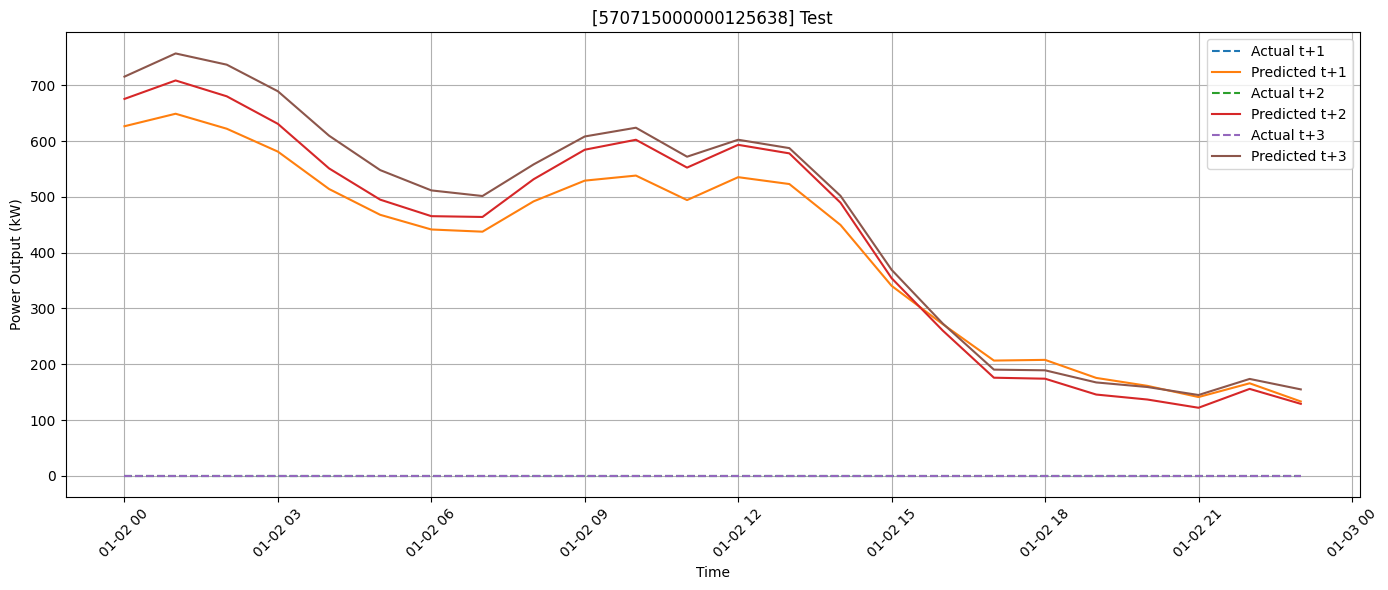

In [59]:
model_test(
    model=model,
    data_paths=test_data_paths,
    x_scaler_dict=x_scaler,
    y_scaler_dict=y_scaler,
    round_predictions=False,

)